In [1]:
import os
import json

import numpy as np

import matplotlib
import matplotlib.pyplot as plt


import detectron2
import detectron2.data.transforms as T
from detectron2.structures import BoxMode

import labelme
from labelme import LabelFile
from labelme import utils

import PIL
from PIL import Image

import pickle

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



### Wrapper functions

In [2]:
def json_to_dict(directory, img_height, img_width):
    """
    This is the wrapper function that converts all json files in the designated 
    directory into requred image height and width, and store the dataset as
    a Detectron2 input type.
    Inputs:
        - directory: the directory path where all training .json files are located
        - img_heght: the expected image height after conversion in unit of pixel
        - img_width: the expected image width after conversion in unit of pixel
    Outputs:
        - dataset_dict: list[{dictionary1}, {dictionary2},...]. Each dictionary
                        contains segmentation information for each image.
        - imgs: list[nparray1, nparray2,...]. Each np array signifies an image.
        - polygonlist: list[list[]]
    """
    # Load only .json files in the directory
    path = directory
    valid_filetype = [".json"]
    imgs = []
    polygon_list = []
    dataset_dict = []
    img_num = 0
    for file in os.listdir(path):
        filename = os.path.splitext(file)[0] # filename without extension
        ext = os.path.splitext(file)[1] # find the extension of the file
        if ext.lower() not in valid_filetype:
            continue
        img, polygons = json_to_arrs(file)
        new_img, new_polygons = img_mask_rescale(img, polygons, img_height, img_width)
        img2save = Image.fromarray(new_img)
        img2save.save(filename+".png")
        reshaped_polygons, bb_boxes = polygon_arr_to_list(new_polygons)
        img_dict = to_dict(path, file, img_num, img_height, img_width, reshaped_polygons, bb_boxes)
        dataset_dict.append(img_dict)
        # Append to global lists for secondary outputs
        imgs.append(new_img)
        polygon_list.append(new_polygons)
        img_num = img_num+1
    return dataset_dict, imgs, polygon_list #imgs,polygon_list  # list[{image1},{image2}]

In [3]:
def show_img_and_mask_json(json_file):
    """
    This function shows the image and the mask from a .json file.
    Input: 
        -.json file that stores the image in the dictionary key "imageData"
          and the mask information in the dictionary key "shapes"
    Output:
        - Inline plot with image and mask
    """
    img, polys = json_to_arrs(json_file)
    plt.imshow(img,alpha=1)
    mask = []
    for index,item in enumerate(polys):
        poly = item.tolist()
        poly.append(item[-1].tolist())
        x, y = zip(*poly)
        mask.append(plt.fill(x,y,alpha=0.5,color="y"))
    for index,item in enumerate(mask):
        plt.show(mask[index])

### Other Functions

In [4]:
def json_to_arrs(json_file):
    """
    Load a single image and its corresponding polygon masks from a jsonfile
    Output a list of images in np arrays and a list of polygon masks in np array
    Inputs:
    
    """
    # Load data from json
    data = json.load(open(json_file))
    # Append images to a list of nd arrays
    img_data = data.get("imageData")
    img = labelme.utils.img_b64_to_arr(img_data) # load image to np array
    # Append mask to a list of polygons
    poly = data.get("shapes")
    poly_for_single_img = []
    for polyitem in poly:
        polygon = np.array(polyitem.get("points"))
        polygon = np.reshape(polygon,(len(polygon),2))
        poly_for_single_img.append(polygon)

    return img, poly_for_single_img

In [5]:
def show_img_and_mask(imgs,polygon_list):
    """
    Input:
        - list of nd array images
        - list of polygon mask vertex coordinates
    Output:
        - Inline plot with images and masks
    """
    mask = []
    for img_num,polygon in enumerate(polygon_list):
        plt.figure()
        plt.imshow(imgs[img_num],alpha=1)
        for mask_num,item in enumerate(polygon):
            poly = item.tolist()
            poly.append(item[-1].tolist())
            #print(poly)
            x, y = zip(*poly)
            mask.append(plt.fill(x,y,alpha=0.5,color="y"))
    for index,item in enumerate(mask):
        plt.show(mask[index])

In [6]:
# Reshaped polygon list to Detectron2 acceptable format
def polygon_arr_to_list(polygons):
    """
    This funtion converts the a list of polygons for single image to 
    Detectron2 accpeted format and find the bounding boxes
    """
    reshaped_polys = []
    bb_boxes =[]
    for ind, polygon in enumerate(polygons):
        #print(polygon)
        reshaped_poly = polygon.reshape(1,polygon.shape[0]*polygon.shape[1]).tolist()[0]            
        # [min_x, min_y, max_x, max_y]
        bb_box = [np.min(reshaped_poly[0::2]),
                np.min(reshaped_poly[1::2]),
                np.max(reshaped_poly[0::2]),
                np.max(reshaped_poly[1::2])]
        reshaped_polys.append(reshaped_poly)
        bb_boxes.append(bb_box)
    return reshaped_polys, bb_boxes

In [7]:
def img_mask_rescale(img, polygons, height, width):
    """
    Rescale image and masks to designated height and width.
    Return new img as np array, new maks as a list of np array
    """
    scale = T.ScaleTransform(np.shape(img)[0],np.shape(img)[1], height, width)
    new_img = scale.apply_image(img, "bilinear")
    new_poly = scale.apply_polygons(polygons)
    return new_img, new_poly

In [8]:
def to_dict(path,jsonfile,img_num,height,width,reshaped_polygon_list, bb_box_list):
    """
    Save all information into detectron2 dictionary
    """
    filename = os.path.splitext(jsonfile)[0]
    new_filename = filename+".png" # create new json filename
    single_img_dict = {}
    single_img_dict["file_name"] = new_filename
    single_img_dict["image_id"] = img_num
    single_img_dict["height"] = height 
    single_img_dict["width"] = width
    
    # Initiate list of dict [{instance1},{instance2},{instance3}}]]
    # Each dict corresponds to annotations of one instance in this image
    objs = []            
    for instance,mask in enumerate(reshaped_polygon_list):
        anno = {}
        # Record segmentation as list[list[float]] as required by Detectron2
        # Each list[float] is one instance
        # in the format of [x1, y1, ..., xn, yn] (in unit of pixels).
        anno["segmentation"] = [reshaped_polygon_list[instance]]
        # Record mask bounding box
        anno["bbox"] = bb_box_list[instance] # Bounding box
        anno["bbox_mode"] = BoxMode.XYXY_ABS # Type of bounding box
        # Record category label: there is only one category, so always 0
        anno["category_id"] = 0 
        objs.append(anno)
    single_img_dict["annotations"] = objs # list of dict [{instance1},{instance2},{instance3}}]]
    return single_img_dict # {image1}

In [9]:
def dictionary_fuction_for_detectron2(directory, img_height, img_width):
    dictionary, imgs, polygon_list = json_to_dict(directory, img_height, img_width)
    return dictionary

### Test with curret directory

In [10]:
dictionary,imgs,polygon_list = json_to_dict("./",400,800)
#print(img[0])
#print(dictionary)
#print(imgs)
#print(polygon[0][0])


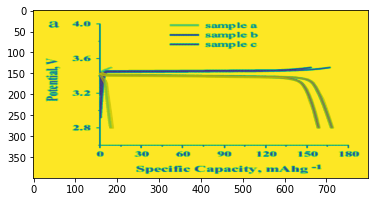

In [11]:
show_img_and_mask(imgs,polygon_list)

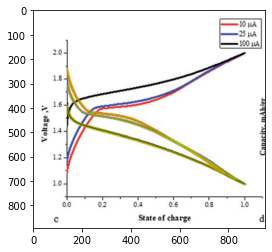

In [12]:
show_img_and_mask_json("abc.json")

### Register Dataset

In [13]:
#json_to_dict("./",400,800)

In [14]:
from detectron2.data import DatasetCatalog, MetadataCatalog
path = "./"
DatasetCatalog.register("discharge_curve", lambda: dictionary_fuction_for_detectron2(path,400,800))
MetadataCatalog.get("discharge_curve").set(thing_classes=["DischargeCurve"])


namespace(name='discharge_curve', thing_classes=['DischargeCurve'])

In [15]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
cfg = get_cfg()
cfg.OUTPUT_DIR = "./output"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

In [16]:
#DatasetCatalog.get("discharge_curve")

In [17]:
cfg.DATASETS.TRAIN = ("discharge_curve",)     # our training dataset
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2     # number of parallel data loading workers
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")     # use pretrained weights
cfg.SOLVER.IMS_PER_BATCH = 2     # in 1 iteration the model sees 2 images
cfg.SOLVER.BASE_LR = 0.00025     # learning rate
cfg.SOLVER.MAX_ITER = 10        # number of iteration
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1     # number of proposals to sample for training
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (mango)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

#### Extra settings for cpu only scenario
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.RPN.BBOX_REG_LOSS_TYPE = "smooth_l1"
cfg.MODEL.RPN.BBOX_REG_LOSS_WEIGHT = 1.0
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = "smooth_l1"
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT = 1.0





In [18]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[INFO   ] defaults:build_model:436 - Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[INFO   ] defaults:build_model:436 - Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[INFO   ] build:filter_images_with_only_crowd_annotations:61 - Removed 0 images with no usable annotations. 2 images left.
[INFO   ] build:filter_images_with_only_crowd_annotations:61 - Removed 0 images with no usable annotations. 2 images left.
[INFO   ] logger:log_first_n:168 - Distribution of instances among all 1 categories:
|   category    | #instances   |
|:-------------:|:-------------|
| DischargeCu.. | 6            |
|               |              |
[INFO   ] logger:log_first_n:168 - Distribution of instances among all 1 categories:
|   category    | #instances   |
|:-------------:|:-------------|
| DischargeCu.. | 6            |
|               |              |
[INFO   ] dataset_mapper:__init__:83 - [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[INFO   ] dataset_mapper:__init__:83 - [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(sho

In [24]:
# Update weights in the configuration
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
# Set up test sets


In [25]:
### Save the neural network as .pkl file
filename = './output/config.pkl'
with open(filename, 'wb') as file:
     pickle.dump(cfg, file)

### Load the Trained Neural Network

In [103]:
def read_img_to_BGR(image_file):
    """
    This functions read .PNG files into BGR nd array.
    Input:
        - image_file: .png image file
    Output: 
        - BGR_img: nd array with size (image_height, image_width, 3)
    """
    im = Image.open(image_file) # Read R,G,B, and alpha
    img_array = np.array(im) 
    # Convert to BGR
    BGR_img = np.empty((img_array.shape[0],img_array.shape[1],3))
    BGR_img[:,:,0] = img_array[:,:,2]
    BGR_img[:,:,1] = img_array[:,:,1]
    BGR_img[:,:,2] = img_array[:,:,0]
    return BGR_img

In [98]:
img = read_img_to_BGR("abc.PNG")

In [104]:
def predict_discharge_curve(PNG_image):
    # Load the neural network as .pkl file
    with open(filename, 'rb') as file:
        cfg = pickle.load(file)
    # Use Default predictor to load the pretrained NN
    predictor = DefaultPredictor(cfg)
    BGR_image = read_img_to_BGR(PNG_image)
    predict_dict = predictor(BGR_image)
    return predict_dict

In [105]:
outputs = predict_discharge_curve("abc.PNG")

[INFO   ] checkpoint:load:138 - Loading checkpoint from ./output/model_final.pth


In [107]:
# Use Default predictor to load the pretrained NN
# https://github.com/facebookresearch/detectron2/blob/master/detectron2/engine/defaults.py
def load_trained_nn(pickel_file):
    with open(filename, 'rb') as file:
        cfg = pickle.load(file)
    # Use Default predictor to load the pretrained NN
    predictor = DefaultPredictor(cfg)
    return predictor

In [108]:
predictor = load_trained_nn("./output/config.pkl")

[INFO   ] checkpoint:load:138 - Loading checkpoint from ./output/model_final.pth
